In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import sys
from pathlib import Path
path = Path(os.getcwd()).resolve().parent.parent
if path not in sys.path:
    sys.path.append(str(path))
    
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from src.data.save_results import save_model_scores

In [10]:
DATA = path / "data"
TRAINED_DATA = DATA / "trained_data"
MODELS = DATA / "models"
METHOD = "SingleOutput"


In [11]:
def angular_error(y_true, y_pred):
    diff = y_pred - y_true
    return np.arctan2(np.sin(diff), np.cos(diff))

def angular_r2_score(y_true, y_pred):
    err = angular_error(y_true, y_pred)
    ss_res = np.sum(err**2)
    # Sử dụng trung bình làm baseline (góc trung bình tuần hoàn)
    sin_mean = np.mean(np.sin(y_true))
    cos_mean = np.mean(np.cos(y_true))
    mean_angle = np.arctan2(sin_mean, cos_mean)
    ss_tot = np.sum(angular_error(y_true, mean_angle)**2)
    return 1 - ss_res / ss_tot


<<=====|LinearRegression|=====>>
[MAE]: 0.10 rad ~ 5.67°
[RMSE]: 0.13 rad ~ 7.21°
[R2]: 0.86
<<=======================>>
<<=====|RandomForestRegressor|=====>>
[MAE]: 0.03 rad ~ 1.70°
[RMSE]: 0.04 rad ~ 2.20°
[R2]: 0.99
<<=======================>>
<<=====|GradientBoostingRegressor|=====>>
[MAE]: 0.05 rad ~ 2.65°
[RMSE]: 0.07 rad ~ 4.18°
[R2]: 0.95
<<=======================>>
<<=====|XGBoostRegressor|=====>>
[MAE]: 0.03 rad ~ 1.71°
[RMSE]: 0.04 rad ~ 2.11°
[R2]: 0.99
<<=======================>>
<<=====|LightGBMRegressor|=====>>
[MAE]: 0.04 rad ~ 2.35°
[RMSE]: 0.05 rad ~ 2.94°
[R2]: 0.98
<<=======================>>
<<=====|SupportVectorRegression|=====>>
[MAE]: 0.06 rad ~ 3.16°
[RMSE]: 0.09 rad ~ 4.95°
[R2]: 0.93
<<=======================>>
Saved evaluation results to: C:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\data\scores&predictions\SingleOutput\wind_direction_10m


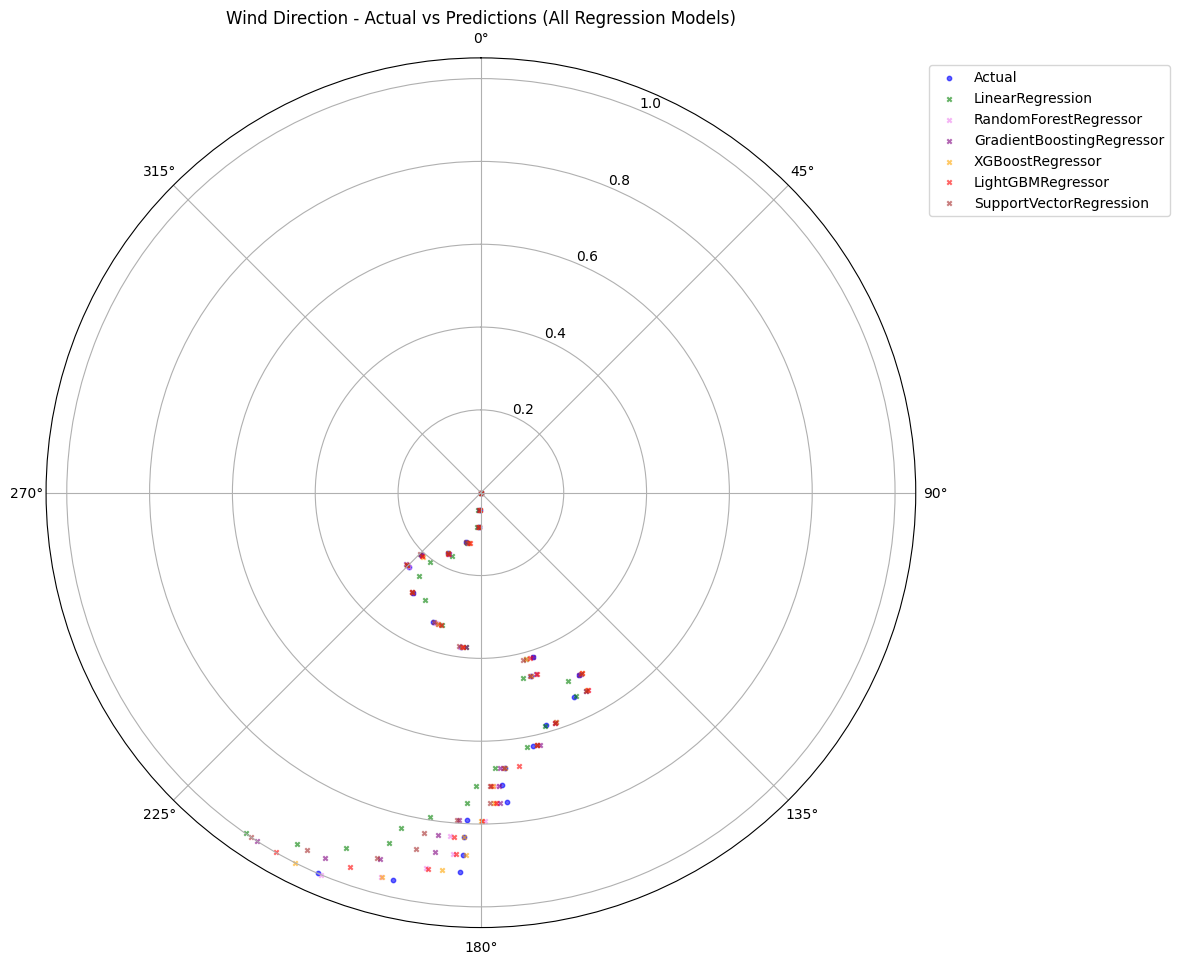

In [12]:

# Đọc dữ liệu
test_df_sin = pd.read_csv(f"{TRAINED_DATA}/{METHOD}/wind_direction_10m_sin/test_df.csv", parse_dates=["date"])
model_predictions_sin = pd.read_csv(f"{DATA}/scores&predictions/{METHOD}/wind_direction_10m_sin/model_predictions.csv")

test_df_cos = pd.read_csv(f"{TRAINED_DATA}/{METHOD}/wind_direction_10m_cos/test_df.csv", parse_dates=["date"])
model_predictions_cos = pd.read_csv(f"{DATA}/scores&predictions/{METHOD}/wind_direction_10m_cos/model_predictions.csv")

# Gán cột date
matching_sin = model_predictions_sin["actual"].values == test_df_sin["wind_direction_10m_sin"].values
model_predictions_sin["date"] = np.where(matching_sin, test_df_sin["date"].values, pd.NaT)
model_predictions_sin["date"] = pd.to_datetime(model_predictions_sin["date"], errors="coerce")

matching_cos = model_predictions_cos["actual"].values == test_df_cos["wind_direction_10m_cos"].values
model_predictions_cos["date"] = np.where(matching_cos, test_df_cos["date"].values, pd.NaT)
model_predictions_cos["date"] = pd.to_datetime(model_predictions_cos["date"], errors="coerce")

# Lọc khoảng thời gian
mask = (model_predictions_sin["date"] >= "2016-06-01") & (model_predictions_sin["date"] <= "2016-06-02")

# Tính hướng gió thực
theta_actual = np.arctan2(
    model_predictions_sin["actual"].values[mask],
    model_predictions_cos["actual"].values[mask]
)
r = np.linspace(0, 1, len(theta_actual))

# Tên mô hình và màu sắc
models = {
    "LinearRegression": "green",
    "RandomForestRegressor": "violet",
    "GradientBoostingRegressor": "purple",
    "XGBoostRegressor": "orange",
    "LightGBMRegressor": "red",
    "SupportVectorRegression": "brown"
}

# Vẽ biểu đồ tròn
fig, ax = plt.subplots(figsize=(12, 12), subplot_kw={'projection': 'polar'})

# Vẽ điểm thực tế
ax.scatter(theta_actual, r, c='blue', s=10, label="Actual", alpha=0.6)

results = []
# Vẽ từng mô hình
for model_name, color in models.items():
    theta_pred = np.arctan2(
        model_predictions_sin[f"{model_name}_pred"].values[mask],
        model_predictions_cos[f"{model_name}_pred"].values[mask]
    )
    ax.scatter(theta_pred, r, s=10, label=model_name, alpha=0.6, marker='x', c=color)
    
    errors = angular_error(theta_actual, theta_pred)
    mae_wind_direction_10m = np.mean(np.abs(errors))
    rmse_wind_direction_10m = np.sqrt(np.mean(errors**2))
    r2_wind_direction_10m = angular_r2_score(theta_actual, theta_pred)
    results.append({
        "Model": model_name,
        "MAE (rad)": mae_wind_direction_10m,
        "MAE (°)": mae_wind_direction_10m * 180 / np.pi,
        "RMSE (rad)": rmse_wind_direction_10m,
        "RMSE (°)": rmse_wind_direction_10m * 180 / np.pi,
        "Angular R²": r2_wind_direction_10m
    })

    print(f"<<=====|{model_name}|=====>>")
    print(f"[MAE]: {mae_wind_direction_10m:.2f} rad ~ {mae_wind_direction_10m * 180 / np.pi:.2f}°")
    print(f"[RMSE]: {rmse_wind_direction_10m:.2f} rad ~ {rmse_wind_direction_10m * 180 / np.pi:.2f}°")
    print(f"[R2]: {r2_wind_direction_10m:.2f}")
    print("<<=======================>>")

df_results = pd.DataFrame(results)
output_path = Path(DATA) / "scores&predictions" / METHOD / "wind_direction_10m"
if not output_path.exists():
    output_path.mkdir(parents=True, exist_ok=True)
df_results.to_csv(output_path / "model_scores.csv", index=False)
print(f"Saved evaluation results to: {output_path}")

# Cấu hình biểu đồ
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
plt.title("Wind Direction - Actual vs Predictions (All Regression Models)", fontsize=12)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
plt.grid(True)
plt.tight_layout()
plt.show()
